In [266]:
import math 
from sympy import * 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [267]:
# optimal individual total profit function 
def opt_ind_total_profit(A, shippers):
    for i in range(len(shippers)):
        shippers[i]["opt_ind_TP"] = shippers[i]["revenue"]*shippers[i]["rate"] - sqrt(2*A*shippers[i]["cost"]*shippers[i]["rate"])
    
    return shippers

In [268]:
# optimal total profit function under cooperative game 

#total profit function among s shipper
def total_profit_s (n_full,n_shipper,A,shippers, T):
    TP_s = (sum( shippers[i]["revenue"]*shippers[i]["rate"] for i in range(1, n_full+1) ) + 
            sum( shippers[i]["revenue"]**2*shippers[i]["rate"]  / (2*shippers[i]["cost"]*T )    for i in range(n_full+1,n_shipper+1)) -
            ( A/T - sum( shippers[i]["cost"]**shippers[i]["rate"] *T/2   for i in range(1, n_full+1) )
            )
    )
    return TP_s

#finding optimal total profit for cooperative game 
def opt_coop_total_profit(A,shippers ):
    # finding  optimal T among s shipper 
    opt_coop_TP = 0 
    s = len(shippers)
    k = s-1
    l = None
    trend = True
    # algorithm 1
    for k in range(s-2):
        #variable
        T = Symbol("T")
        #total profit function expression
        exp1 =(sum( shippers[i]["revenue"]*shippers[i]["rate"] for i in range(0, k+1) ) + 
            sum( (shippers[i]["revenue"]**2)*shippers[i]["rate"]  / (2*shippers[i]["cost"]*T )    for i in range(k+1,s)) -
            ( A/T + sum( shippers[i]["cost"]*shippers[i]["rate"] *T/2   for i in range(0, k+1) )
            )
        )
        dif1 = diff(exp1, T)
        result1 = lambdify(T,dif1)
        exp2 =(sum( shippers[i]["revenue"]*shippers[i]["rate"] for i in range(0, k+2) ) + 
            sum( (shippers[i]["revenue"]**2)*shippers[i]["rate"]  / (2*shippers[i]["cost"]*T )    for i in range(k+2,s)) -
            ( A/T + sum( shippers[i]["cost"]*shippers[i]["rate"] *T/2   for i in range(0, k+2) )
            )
        )

        dif2 = diff(exp2, T)
        result2 = lambdify(T,dif2)
        if  result1(shippers[k]["revenue"] / shippers[k]["cost"] ) >= 0 and result2(shippers[+1]["revenue"] / shippers[k+1]["cost"] ) >= 0   :
            trend = False
        elif result1(shippers[k]["revenue"] / shippers[k]["cost"] ) >= 0 and result2(shippers[k+1]["revenue"] / shippers[k+1]["cost"] )<= 0   :
            l = k     
            trend = False
            break

    if l == None and trend == True:
        l = s-1
    elif l == None and trend == False:
        opt_coop_TP = 0 
        for i in range(s):
            shippers[i]["opt_coop_TP"] = 0
            shippers[i]["participation-coop"] = "-"
            
    
    # number of full shippers are found : l 
    # now T^* can be implemented
    opt_exp_t = math.sqrt(2*(A - sum( (shippers[i]["revenue"]**2)*shippers[i]["rate"] / (2*shippers[i]["cost"]  )    
                        for i in range(l+1,s))) / 
                        sum( shippers[i]["revenue"]*shippers[i]["rate"]  for i in range(0, l+1)) )    

    #assigning profit allocation for each shipper
    for i in range(s):
        if  shippers[i]["revenue"] / shippers[i]["cost"] < opt_exp_t :
            shippers[i]["opt_coop_TP"] = 0
            shippers[i]["participation-coop"] = "partial"
            opt_coop_TP += shippers[i]["opt_coop_TP"]
        elif shippers[i]["revenue"] / shippers[i]["cost"] >= opt_exp_t : 
            shippers[i]["opt_coop_TP"] =  shippers[i]["rate"]*(shippers[i]["revenue"] - shippers[i]["cost"]*opt_exp_t)
            shippers[i]["participation-coop"] = "full time"
            opt_coop_TP += shippers[i]["opt_coop_TP"]

        
    return shippers, opt_coop_TP


    

In [269]:
#finding optimal total profit for non-cooperative game 
def opt_noncoop_total_profit(A,shippers ):
    opt_noncoop_TP = 0 
    check = False


    #finding individual optimal cycle time, t_i^*
    for s in range(len(shippers)):
        shippers[s]["t_i^*"] = math.sqrt(2*A/(shippers[s]["cost"] *shippers[s]["rate"] ))
        
        if  shippers[s]["opt_ind_TP"] > 0 : 
            check = True
            
    if check == True :


        #finding best response - contibution amount 
        shippers_sorted = sorted(shippers, key= lambda d: d["t_i^*"], reverse = False)

        shippers_sorted = list(filter(lambda x: (x["opt_ind_TP"] > 0), shippers_sorted  ))
        min_t_i = shippers_sorted[0]["t_i^*"]   

        contribution_amount = math.sqrt(shippers_sorted[0]["cost"] *shippers_sorted[0]["rate"]*A/2 )

        
        #finding total profit made 
        for s in range(len(shippers)):
            if shippers[s]["t_i^*"] == min_t_i:
                c_i = contribution_amount
            else: 
                c_i = 0
            #determining partial/full shippers, min_t_i^* will be equal to shared cycle time.
            if shippers[s]["revenue"] / shippers[s]["cost"] > min_t_i : 
                shippers[s]["opt_noncoop_TP"] = ((shippers[s]["revenue"]*shippers[s]["rate"] ) - c_i - 
                                    (shippers[s]["cost"]*shippers[s]["rate"] *A/(2*contribution_amount) )
                )
                shippers[s]["participation-non"] = "full time"  
                opt_noncoop_TP += shippers[s]["opt_noncoop_TP"] 

            elif  shippers[s]["revenue"]  / shippers[s]["cost"]<= min_t_i :
                shippers[s]["opt_noncoop_TP"] =  (shippers[s]["revenue"]**2*shippers[s]["rate"] / (2*shippers[s]["cost"])*
                                    (contribution_amount/A) - c_i )
                opt_noncoop_TP += shippers[s]["opt_noncoop_TP"]     
                shippers[s]["participation-non"] = "partial time" 
            

        # partials do not contribute, full shippers totally contribute as the amount of contribution_amount
        # need to decrease totally contribution_amount from total profit
    else:
        for s in range(len(shippers)):
            shippers[s]["opt_noncoop_TP"] = 0
            shippers[s]["participation-non"] = "-" 
            opt_noncoop_TP = shippers[s]["opt_noncoop_TP"]

    return shippers, opt_noncoop_TP 

In [270]:
import random
from collections import defaultdict
#creating scenerios 
#base case

A = 100
number_of_shippers = 5 
revenue = np.random.uniform(low=5, high=30 )
cost  = np.random.uniform(low=2, high=7)
rate = np.random.uniform(low=2, high=10 )



In [271]:
#creating shippers

number_of_shippers_ = [3,5, 10, 20]
shippers_ = []
shippers_base = []
shippers_n =defaultdict(list)
for scenario in number_of_shippers_ :
    for i in range(scenario):
        shippers_n[scenario].append(
            {
                "revenue" : np.random.uniform(low=5, high=30 ), #5,30
                "cost" : np.random.uniform(low=2, high=7), 
                "rate" : np.random.uniform(low=2, high=10 ),
            }
        )
        shippers_n[scenario][-1]["r/c"] = shippers_n[scenario][-1]["revenue"] / shippers_n[scenario][-1]["cost"]
        shippers_n[scenario] = opt_ind_total_profit(A, shippers_n[scenario])

    shippers_n[scenario] = sorted(shippers_n[scenario], key=lambda d: d['r/c'], reverse = True )



In [272]:
# changing number_of_shippers 

selfish_scenario_TP_n = defaultdict(list)
cooperative_scenario_TP_n = defaultdict(list)

scenario_n = {}
for scenario in number_of_shippers_ :

    shippers_n[scenario], selfish_scenario_TP_n[scenario] = opt_noncoop_total_profit(A,shippers_n[scenario] )
    shippers_n[scenario], cooperative_scenario_TP_n[scenario] = opt_coop_total_profit(A, shippers_n[scenario])
    #creating result tables for this test 

    #shippers table
    df = pd.DataFrame.from_dict(shippers_n[scenario])
    df["price of anarchy"] = 1 - (df["opt_noncoop_TP"]   /  df["opt_coop_TP"] )
    df.loc[df["price of anarchy"] <= 0, "price of anarchy"] = 0
    scenario_n[scenario] = df

#summary table for n shipper case: 
df2 = pd.DataFrame(columns = ["Number of Shipper","Non Cooperative Total Profit", "Cooperative Total Profit", "Price of Anarchy"])

for scenario in number_of_shippers_:
    tem_len = len(df2)
    df2.loc[tem_len] = [int(scenario),
                        selfish_scenario_TP_n[scenario], 
                        cooperative_scenario_TP_n[scenario],  
                        1 - (selfish_scenario_TP_n[scenario] / cooperative_scenario_TP_n[scenario]) ]

with pd.ExcelWriter("ShipperSizeAnalysis.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    df2.to_excel(writer, sheet_name="Summary", index=False)
    for scenario in number_of_shippers_ :
        scenario_n[scenario].to_excel(writer, sheet_name=f"Shippers_{scenario}", index=False)


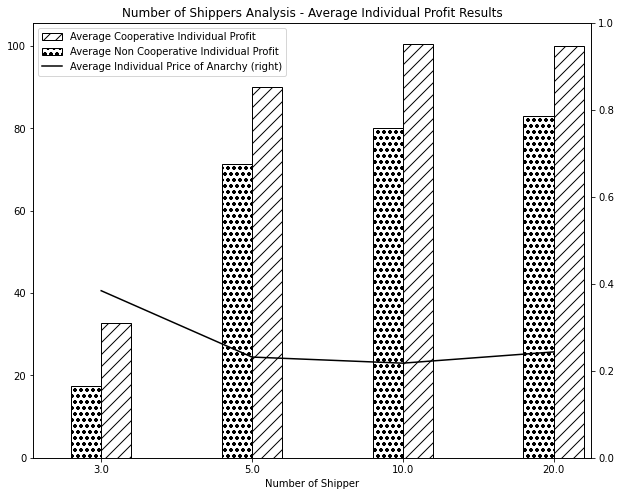

In [273]:
#average table for n shipper case: 
df3_n = pd.DataFrame(columns = ["Number of Shipper",
                            "Average Non Cooperative Individual Profit",
                            "Average Cooperative Individual Profit", 
                            "Average Individual Price of Anarchy"])

for key in scenario_n.keys():
    avg_coop_TP = scenario_n[key]["opt_coop_TP"].mean()
    avg_noncoop_TP = scenario_n[key]["opt_noncoop_TP"].mean()
    avg_poa = scenario_n[key]["price of anarchy"].mean()
    tem_len = len(df3_n)
    df3_n.loc[tem_len] = [int(key),
                        avg_noncoop_TP, 
                        avg_coop_TP,  
                        avg_poa ]

fig, ax = plt.subplots(figsize=(10,8)) 

df3_n.plot.bar(x="Number of Shipper", y = "Average Cooperative Individual Profit", 
            color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2,rot = 0)
df3_n.plot.bar(x="Number of Shipper", y = "Average Non Cooperative Individual Profit" , 
            color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2,rot = 0)

df3_n["Average Individual Price of Anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, 
                                                 use_index=True, kind ="line", legend = True ,rot = 0)
ax.right_ax.set_ylim(0,1)
plt.title("Number of Shippers Analysis - Average Individual Profit Results")
plt.savefig('Average Individual Profit-NumberofShippersAnalysis.png',facecolor="white", edgecolor='none')   

In [274]:
""" # r/c shippers 
for key in scenario_n.keys():
    fig, ax = plt.subplots(figsize=(10,5)) 
    scenario_n[key]= scenario_n[key].sort_values("r/c", )
    scenario_n[key]= scenario_n[key].reset_index(drop= True)
    scenario_n[key].plot.bar(x="r/c", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)
    scenario_n[key].plot.bar(x="r/c", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )
    scenario_n[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)


    labels= list(round(scenario_n[key]["r/c"],2))
    ax.set_xticklabels(labels, rotation=0)

    plt.title(f"Number of Shippers Analysis - {key} Shipper Results according to their r/c values")
    plt.savefig(f'{key} Shippers-NumberofShippersAnalysis- rc.png',facecolor="white", edgecolor='none') """

' # r/c shippers \nfor key in scenario_n.keys():\n    fig, ax = plt.subplots(figsize=(10,5)) \n    scenario_n[key]= scenario_n[key].sort_values("r/c", )\n    scenario_n[key]= scenario_n[key].reset_index(drop= True)\n    scenario_n[key].plot.bar(x="r/c", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)\n    scenario_n[key].plot.bar(x="r/c", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )\n    scenario_n[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)\n\n\n    labels= list(round(scenario_n[key]["r/c"],2))\n    ax.set_xticklabels(labels, rotation=0)\n\n    plt.title(f"Number of Shippers Analysis - {key} Shipper Results according to their r/c values")\n    plt.savefig(f\'{key} Shippers-NumberofShippersAnalysis- rc.png\',facecolor="white", edgecolor=\'none\') '

In [275]:
""" #t_i^* analysis

for key in scenario_n.keys():
    fig, ax = plt.subplots(figsize=(10,5)) 
    scenario_n[key]= scenario_n[key].sort_values("t_i^*", )
    scenario_n[key]= scenario_n[key].reset_index(drop= True)
    scenario_n[key].plot.bar(x="t_i^*", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)
    scenario_n[key].plot.bar(x="t_i^*", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )
    scenario_n[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)



    labels= list(round(scenario_n[key]["t_i^*"],2))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel("$t_i^*$")

    plt.title(f"Number of Shippers Analysis - {key} Shipper Results according to their $t_i^*$ values")
    plt.savefig('Shippers-NumberofShippersAnalysis-t_i.png',facecolor="white", edgecolor='none') """

' #t_i^* analysis\n\nfor key in scenario_n.keys():\n    fig, ax = plt.subplots(figsize=(10,5)) \n    scenario_n[key]= scenario_n[key].sort_values("t_i^*", )\n    scenario_n[key]= scenario_n[key].reset_index(drop= True)\n    scenario_n[key].plot.bar(x="t_i^*", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)\n    scenario_n[key].plot.bar(x="t_i^*", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )\n    scenario_n[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)\n\n\n\n    labels= list(round(scenario_n[key]["t_i^*"],2))\n    ax.set_xticklabels(labels, rotation=0)\n    ax.set_xlabel("$t_i^*$")\n\n    plt.title(f"Number of Shippers Analysis - {key} Shipper Results according to their $t_i^*$ values")\n    plt.savefig(\'Shippers-NumberofShippersAnalysis-t_i.png\',facecolor="white", edgecol

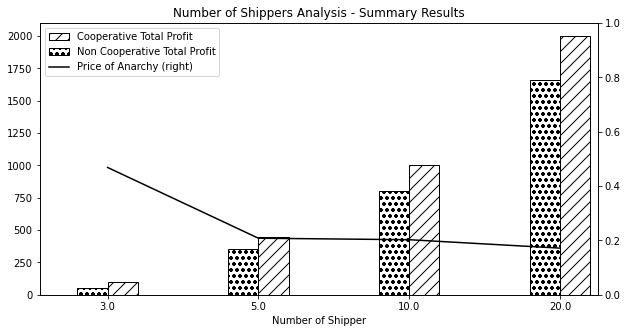

In [276]:
fig, ax = plt.subplots(figsize=(10,5)) 

hatches = ['//' ,'++', 'xx','||', 'oo','--','OO', '..', '**' , '\\\\']
df2.plot.bar(x="Number of Shipper", y = "Cooperative Total Profit", color = "white", 
            edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2,rot = 0)
df2.plot.bar(x="Number of Shipper", y = "Non Cooperative Total Profit" , color = "white", 
            edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2,rot = 0)

df2["Price of Anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True,
                             use_index=True, kind ="line", legend = True, rot = 0)

ax.right_ax.set_ylim(0,1)
plt.title("Number of Shippers Analysis - Summary Results")
plt.savefig('Summary-NumberofShippersAnalysis.png',facecolor="white", edgecolor='none')

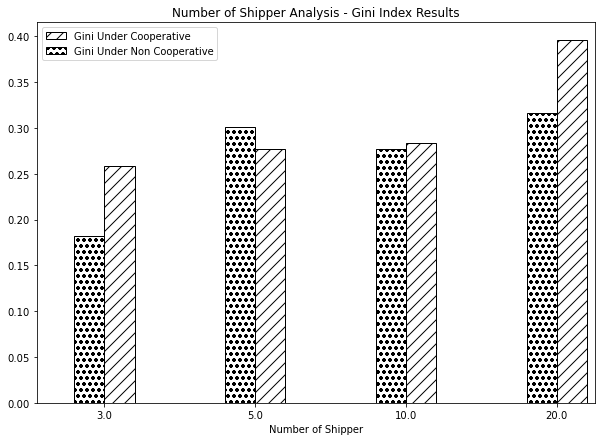

In [277]:
#Gini Index  
df4_n= pd.DataFrame(columns = ["Number of Shipper",
                        "Gini Under Cooperative",
                        "Gini Under Non Cooperative", ])

for key in scenario_n.keys():
    df_gini_rate = scenario_n[key].sort_values(by = ["opt_noncoop_TP"], ignore_index = True) 
    total_non_coop = scenario_n[key]["opt_noncoop_TP"].sum()
    total_coop = scenario_n[key]["opt_coop_TP"].sum()


    normalized_TP_sum = []
    perfect_equality = []
    area_A = []
    area_A_B = []
    for shipper in range(len(df_gini_rate)):
        if shipper == 0 :
            normalized_TP_sum.append( df_gini_rate.loc[shipper,"opt_noncoop_TP"] / total_non_coop )
            perfect_equality.append( 1 / len(df_gini_rate) )
            area_A.append( perfect_equality[shipper] - normalized_TP_sum[shipper])
            area_A_B.append( perfect_equality[shipper])
        else: 
            normalized_TP_sum.append(normalized_TP_sum[shipper-1] + df_gini_rate.loc[shipper,"opt_noncoop_TP"] / total_non_coop ) 
            perfect_equality.append( perfect_equality[shipper-1] + 1 / len(df_gini_rate) )   
            area_A.append( perfect_equality[shipper] - normalized_TP_sum[shipper])
            area_A_B.append( perfect_equality[shipper])
    gini_index_noncoop = sum(area_A) / sum(area_A_B)

    normalized_TP_sum_c = []
    perfect_equality_c = []
    area_A_c = []
    area_A_B_c = []

    for shipper in range(len(df_gini_rate)):
        if shipper == 0 :
            normalized_TP_sum_c.append( df_gini_rate.loc[shipper,"opt_coop_TP"] / total_coop )
            perfect_equality_c.append( 1 / len(df_gini_rate) )
            area_A_c.append( perfect_equality_c[shipper] - normalized_TP_sum_c[shipper])
            area_A_B_c.append( perfect_equality_c[shipper])
        else: 
            normalized_TP_sum_c.append(normalized_TP_sum_c[shipper-1] + df_gini_rate.loc[shipper,"opt_coop_TP"] / total_coop ) 
            perfect_equality_c.append( perfect_equality_c[shipper-1] + 1 / len(df_gini_rate) )   
            area_A_c.append( perfect_equality_c[shipper] - normalized_TP_sum_c[shipper])
            area_A_B_c.append( perfect_equality_c[shipper])

    gini_index_coop = sum(area_A_c) / sum(area_A_B_c)
    tmp_len = len(df4_n)
    df4_n.loc[tmp_len] = [key,
                        gini_index_noncoop, 
                        gini_index_coop,  
                        ]
fig, ax = plt.subplots(figsize=(10,7)) 
df4_n.plot.bar(x="Number of Shipper", y = "Gini Under Cooperative", 
            color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2, rot=0)
df4_n.plot.bar(x="Number of Shipper", y = "Gini Under Non Cooperative" , 
            color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2, rot=0)

plt.title("Number of Shipper Analysis - Gini Index Results")
plt.savefig('GiniIndex-NumberofShipperAnalysis.png',facecolor="white", edgecolor='none')

In [278]:
#changing A values

A_values = [10,50,100,150,200,300]
selfish_scenario_TP_a = defaultdict(list)
cooperative_scenario_TP_a = defaultdict(list)
scenario_a = {}
shippers_a = []
shippers_aa = {}
#creating shippers
revenue = []
cost = []
rate = []
for i in range(5):
    shippers_a.append(
        {
            "revenue" : np.random.uniform(low=5, high=30 ),
            "cost" : np.random.uniform(low=2, high=7), 
            "rate" : np.random.uniform(low=2, high=10 ),
        }
    )
    shippers_a[-1]["r/c"] = shippers_a[-1]["revenue"] / shippers_a[-1]["cost"]
    

shippers_a = sorted(shippers_a, key=lambda d: d['r/c'], reverse = True )


for scenario in A_values :
    shippers_a = opt_ind_total_profit(scenario, shippers_a)
    shippers_aa[scenario], selfish_scenario_TP_a[scenario] = opt_noncoop_total_profit(scenario,shippers_a )
    shippers_aa[scenario], cooperative_scenario_TP_a[scenario] = opt_coop_total_profit(scenario, shippers_aa[scenario])
    #creating result tables for this test 

    #shippers table
    df_a1 = pd.DataFrame.from_dict(shippers_aa[scenario])
    df_a1["price of anarchy"] = 1 - (df_a1["opt_noncoop_TP"]   /  df_a1["opt_coop_TP"] )
    df_a1.loc[df_a1["price of anarchy"] <= 0, "price of anarchy"] = 0
    scenario_a[scenario] = df_a1

#summary table for diffrent A case: 
df_a2 = pd.DataFrame(columns = ["A","Non Cooperative Total Profit", "Cooperative Total Profit", "Price of Anarchy"])

for scenario in A_values:
    tem_len = len(df_a2)
    df_a2.loc[tem_len] = [int(scenario),
                        selfish_scenario_TP_a[scenario], 
                        cooperative_scenario_TP_a[scenario],  
                        1 - (selfish_scenario_TP_a[scenario] / cooperative_scenario_TP_a[scenario] )]

with pd.ExcelWriter("TransportationCostAnalysis.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    df_a2.to_excel(writer, sheet_name="Summary", index=False)
    for scenario in A_values :
        scenario_a[scenario].to_excel(writer, sheet_name=f"Tcost={scenario}", index=False)

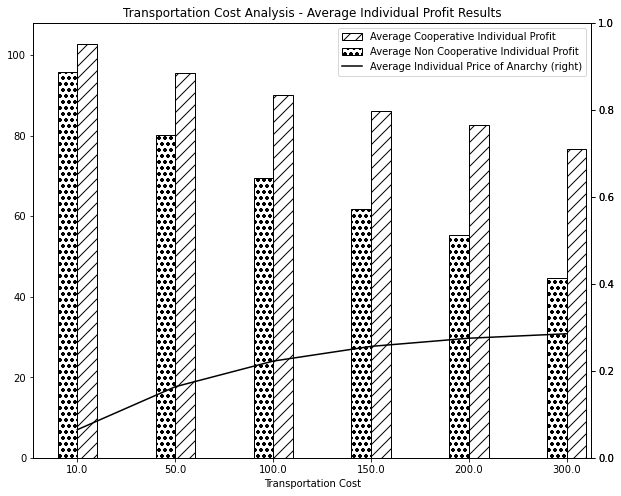

In [279]:
#average table for n shipper case: 
df3_a = pd.DataFrame(columns = ["Transportation Cost",
                            "Average Non Cooperative Individual Profit",
                            "Average Cooperative Individual Profit", 
                            "Average Individual Price of Anarchy"])

for key in scenario_a.keys():
    avg_coop_TP = scenario_a[key]["opt_coop_TP"].mean()
    avg_noncoop_TP = scenario_a[key]["opt_noncoop_TP"].mean()
    avg_poa = scenario_a[key]["price of anarchy"].mean()
    tem_len = len(df3_a)
    df3_a.loc[tem_len] = [int(key),
                        avg_noncoop_TP, 
                        avg_coop_TP,  
                        avg_poa ]

fig, ax = plt.subplots(figsize=(10,8)) 
ax2 = ax.twinx()

ax2.set_ylim(0,1)

df3_a.plot.bar(x="Transportation Cost", y = "Average Cooperative Individual Profit", 
            color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2,rot = 0)
df3_a.plot.bar(x="Transportation Cost", y = "Average Non Cooperative Individual Profit" , 
            color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2,rot = 0)

df3_a["Average Individual Price of Anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, 
                                                use_index=True, kind ="line", legend = True,rot = 0)
ax.right_ax.set_ylim(0,1)
plt.title("Transportation Cost Analysis - Average Individual Profit Results")
plt.savefig('Average Individual Profit-TransportationCostAnalysis.png',facecolor="white", edgecolor='none') 

In [280]:
""" 
# r/c shippers 
for key in scenario_a.keys():
    fig, ax = plt.subplots(figsize=(10,5)) 
    scenario_a[key]= scenario_a[key].sort_values("r/c", )
    scenario_a[key]= scenario_a[key].reset_index(drop= True)
    scenario_a[key].plot.bar(x="r/c", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)
    scenario_a[key].plot.bar(x="r/c", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )
    scenario_a[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)


    labels= list(round(scenario_a[key]["r/c"],2))
    ax.set_xticklabels(labels, rotation=0)

    plt.title(f"Transportation Cost Analysis - Shipper Results according to their r/c values when A={key}")
    plt.savefig(f'A = {key} -TransportationCostAnalysis - rc .png') """

' \n# r/c shippers \nfor key in scenario_a.keys():\n    fig, ax = plt.subplots(figsize=(10,5)) \n    scenario_a[key]= scenario_a[key].sort_values("r/c", )\n    scenario_a[key]= scenario_a[key].reset_index(drop= True)\n    scenario_a[key].plot.bar(x="r/c", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)\n    scenario_a[key].plot.bar(x="r/c", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )\n    scenario_a[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)\n\n\n    labels= list(round(scenario_a[key]["r/c"],2))\n    ax.set_xticklabels(labels, rotation=0)\n\n    plt.title(f"Transportation Cost Analysis - Shipper Results according to their r/c values when A={key}")\n    plt.savefig(f\'A = {key} -TransportationCostAnalysis - rc .png\') '

In [281]:
""" 
for key in scenario_a.keys():
    #t_i^* analysis
    fig, ax = plt.subplots(figsize=(10,5)) 
    scenario_a[key]= scenario_a[key].sort_values("t_i^*", )
    scenario_a[key]= scenario_a[key].reset_index(drop= True)
    scenario_a[key].plot.bar(x="t_i^*", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)
    scenario_a[key].plot.bar(x="t_i^*", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )
    scenario_a[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)



    labels= list(round(scenario_a[key]["t_i^*"],2))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel("$t_i^*$")

    plt.title(f"Transportation Cost Analysis - Shipper Results according to their $t_i^*$ values when A={key}")
    plt.savefig(f'A={key} -TransportationCostAnalysis -t.png',facecolor="white", edgecolor='none') """

' \nfor key in scenario_a.keys():\n    #t_i^* analysis\n    fig, ax = plt.subplots(figsize=(10,5)) \n    scenario_a[key]= scenario_a[key].sort_values("t_i^*", )\n    scenario_a[key]= scenario_a[key].reset_index(drop= True)\n    scenario_a[key].plot.bar(x="t_i^*", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)\n    scenario_a[key].plot.bar(x="t_i^*", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )\n    scenario_a[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)\n\n\n\n    labels= list(round(scenario_a[key]["t_i^*"],2))\n    ax.set_xticklabels(labels, rotation=0)\n    ax.set_xlabel("$t_i^*$")\n\n    plt.title(f"Transportation Cost Analysis - Shipper Results according to their $t_i^*$ values when A={key}")\n    plt.savefig(f\'A={key} -TransportationCostAnalysis -t.png\',facecolor="w

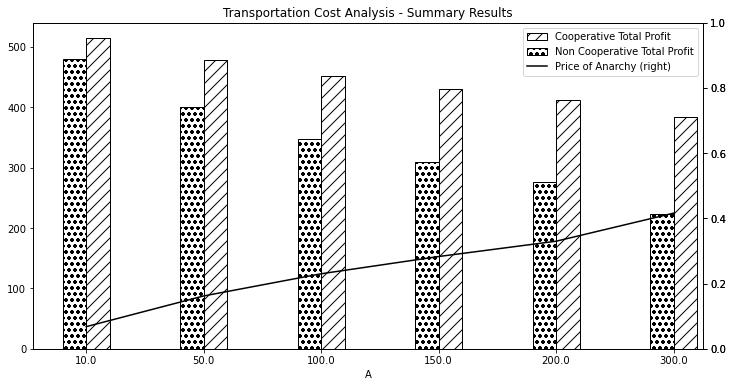

In [282]:
fig, ax = plt.subplots(figsize=(12,6)) 
ax2 = ax.twinx()
ax2.set_ylim(0,1)
hatches = ['//' ,'++', 'xx','||', 'oo','--','OO', '..', '**' , '\\\\']
df_a2.plot.bar(x="A", y = "Cooperative Total Profit", color = "white", edgecolor = "black",
             hatch = "//", ax= ax, position = 0, width = 0.2,rot = 0)
df_a2.plot.bar(x="A", y = "Non Cooperative Total Profit" , color = "white", edgecolor = "black" ,
             hatch = "oo",ax= ax, position = 1, width = 0.2,rot = 0)

df_a2["Price of Anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True,
                         use_index=True, kind ="line", legend=True,rot = 0)

ax.right_ax.set_ylim(0,1)
plt.title("Transportation Cost Analysis - Summary Results")
plt.savefig('Summary-TransportationCostAnalysis.png',facecolor="white", edgecolor='none')

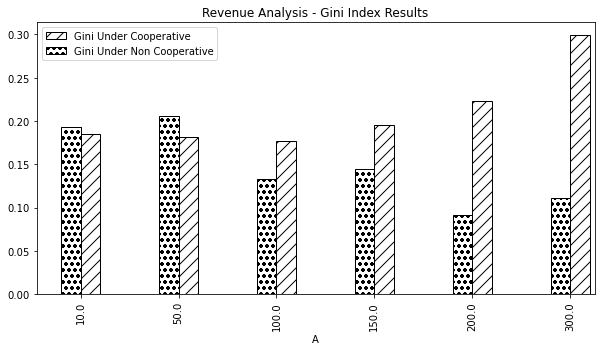

In [283]:
#Gini Index  
df4_a= pd.DataFrame(columns = ["A",
                        "Gini Under Cooperative",
                        "Gini Under Non Cooperative", ])

for key in scenario_a.keys():
    df_gini_rate = scenario_a[key].sort_values(by = ["opt_noncoop_TP"], ignore_index = True) 
    total_non_coop = scenario_a[key]["opt_noncoop_TP"].sum()
    total_coop = scenario_a[key]["opt_coop_TP"].sum()


    normalized_TP_sum = []
    perfect_equality = []
    area_A = []
    area_A_B = []
    for shipper in range(len(df_gini_rate)):
        if shipper == 0 :
            normalized_TP_sum.append( df_gini_rate.loc[shipper,"opt_noncoop_TP"] / total_non_coop )
            perfect_equality.append( 1 / len(df_gini_rate) )
            area_A.append( perfect_equality[shipper] - normalized_TP_sum[shipper])
            area_A_B.append( perfect_equality[shipper])
        else: 
            normalized_TP_sum.append(normalized_TP_sum[shipper-1] + df_gini_rate.loc[shipper,"opt_noncoop_TP"] / total_non_coop ) 
            perfect_equality.append( perfect_equality[shipper-1] + 1 / len(df_gini_rate) )   
            area_A.append( perfect_equality[shipper] - normalized_TP_sum[shipper])
            area_A_B.append( perfect_equality[shipper])
    gini_index_noncoop = sum(area_A) / sum(area_A_B)

    normalized_TP_sum_c = []
    perfect_equality_c = []
    area_A_c = []
    area_A_B_c = []

    for shipper in range(len(df_gini_rate)):
        if shipper == 0 :
            normalized_TP_sum_c.append( df_gini_rate.loc[shipper,"opt_coop_TP"] / total_coop )
            perfect_equality_c.append( 1 / len(df_gini_rate) )
            area_A_c.append( perfect_equality_c[shipper] - normalized_TP_sum_c[shipper])
            area_A_B_c.append( perfect_equality_c[shipper])
        else: 
            normalized_TP_sum_c.append(normalized_TP_sum_c[shipper-1] + df_gini_rate.loc[shipper,"opt_coop_TP"] / total_coop ) 
            perfect_equality_c.append( perfect_equality_c[shipper-1] + 1 / len(df_gini_rate) )   
            area_A_c.append( perfect_equality_c[shipper] - normalized_TP_sum_c[shipper])
            area_A_B_c.append( perfect_equality_c[shipper])

    gini_index_coop = sum(area_A_c) / sum(area_A_B_c)
    tmp_len = len(df4_a)
    df4_a.loc[tmp_len] = [key,
                        gini_index_noncoop, 
                        gini_index_coop,  
                        ]
fig, ax = plt.subplots(figsize=(10,5)) 
df4_a.plot.bar(x="A", y = "Gini Under Cooperative", 
            color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2)
df4_a.plot.bar(x="A", y = "Gini Under Non Cooperative" , 
            color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)

plt.title("Revenue Analysis - Gini Index Results")
plt.savefig('GiniIndex-RevenueAnalysis.png',facecolor="white", edgecolor='none')

In [284]:
#changing revenue values - 3 scenerio
revenue_range = [(5,40), (20,50), (30,70)]
A_r = 100 
shippers_r = defaultdict(list)
cost = {}
rate ={}  
for i in range(5):
    cost[i] = np.random.uniform(low=2, high=7)
    rate[i] =  np.random.uniform(low=2, high=10 )


#creating shippers
for rng in revenue_range:
    for i in range(5):
        shippers_r[rng ].append(
            {
                "revenue" : np.random.uniform(low=rng[0], high=rng[1]),
                "cost" : cost[i], 
                "rate" : rate[i],
            }
        )
        shippers_r[rng ][-1]["r/c"] = shippers_r[rng ][-1]["revenue"] / shippers_r[rng ][-1]["cost"]
        

    shippers_r[rng ] = sorted(shippers_r[rng ], key=lambda d: d['r/c'], reverse = True )

selfish_scenario_TP_r = defaultdict(list)
cooperative_scenario_TP_r = defaultdict(list)
shippers_rr = {}
scenario_r = {}
for key in shippers_r.keys():
    shippers_r[key] = opt_ind_total_profit(A_r, shippers_r[key])
    shippers_rr[key], selfish_scenario_TP_r[key] = opt_noncoop_total_profit(A_r, shippers_r[key] )
    shippers_rr[key], cooperative_scenario_TP_r[key] = opt_coop_total_profit(A_r, shippers_rr[key])
  
    #creating result tables for this test 
    #shippers table
    df_r1 = pd.DataFrame.from_dict(shippers_rr[key])
    df_r1["price of anarchy"] = 1 -( df_r1["opt_noncoop_TP"]   /  df_r1["opt_coop_TP"]) 
    df_r1.loc[df_r1["price of anarchy"] <= 0, "price of anarchy"] = 0
    scenario_r[key] = df_r1
    

#summary table for revenue cases: 
df_r2 = pd.DataFrame(columns = ["Revenue","Non Cooperative Total Profit", "Cooperative Total Profit", "Price of Anarchy"])

for key in shippers_r.keys():
    tem_len = len(df_r2)
    df_r2.loc[tem_len] = ["U[" +  str(key[0]) +","+ str(key[1]) + "]",
                        selfish_scenario_TP_r[key], 
                        cooperative_scenario_TP_r[key],  
                        1 - (selfish_scenario_TP_r[key] / cooperative_scenario_TP_r[key]) ]

with pd.ExcelWriter("RevenueAnalysis.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    df_r2.to_excel(writer, sheet_name="Summary", index=False)
    for key in shippers_r :
        scenario_r[key].to_excel(writer, sheet_name=f"R={key}", index=False)

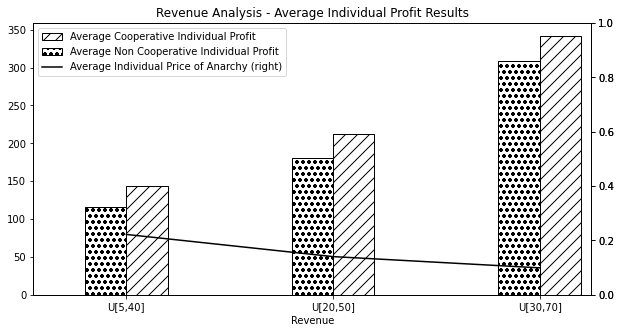

In [285]:
#average table for n shipper case: 
df3_re = pd.DataFrame(columns = ["Revenue",
                            "Average Non Cooperative Individual Profit",
                            "Average Cooperative Individual Profit", 
                            "Average Individual Price of Anarchy"])

for key in scenario_r.keys():
    avg_coop_TP = scenario_r[key]["opt_coop_TP"].mean()
    avg_noncoop_TP = scenario_r[key]["opt_noncoop_TP"].mean()
    avg_poa = scenario_r[key]["price of anarchy"].mean()
    tem_len = len(df3_re)
    df3_re.loc[tem_len] = ["U[" +  str(key[0]) +","+ str(key[1]) + "]",
                        avg_noncoop_TP, 
                        avg_coop_TP,  
                        avg_poa  ]

fig, ax = plt.subplots(figsize=(10,5)) 
ax2 = ax.twinx()
ax2.set_ylim(0,1)

df3_re.plot.bar(x="Revenue", y = "Average Cooperative Individual Profit", 
            color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2,rot = 0)
df3_re.plot.bar(x="Revenue", y = "Average Non Cooperative Individual Profit" , 
            color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2,rot = 0)

df3_re["Average Individual Price of Anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, 
                                                 use_index=True, kind ="line", legend = True,rot = 0)

ax.right_ax.set_ylim(0,1)
plt.title("Revenue Analysis - Average Individual Profit Results")
plt.savefig('Average Individual Profit-RevenueAnalysis.png',facecolor="white", edgecolor='none') 

In [286]:
""" #r/c shippers 
for key in scenario_r.keys():
    fig, ax = plt.subplots(figsize=(10,5)) 
    scenario_r[key]= scenario_r[key].sort_values("r/c", )
    scenario_r[key]= scenario_r[key].reset_index(drop= True)
    scenario_r[key].plot.bar(x="r/c", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)
    scenario_r[key].plot.bar(x="r/c", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )
    scenario_r[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)


    labels= list(round(scenario_r[key]["r/c"],2))
    ax.set_xticklabels(labels, rotation=0)

    plt.title(f"Revenue Analysis - Shipper Results according to their r/c values when R=U[{str(key[0])},{str(key[1])}]")
    plt.savefig(f"R =U[{   str(key[0])},{str(key[1])} ] -RevenueAnalysis - rc.png",facecolor="white", edgecolor='none') """

' #r/c shippers \nfor key in scenario_r.keys():\n    fig, ax = plt.subplots(figsize=(10,5)) \n    scenario_r[key]= scenario_r[key].sort_values("r/c", )\n    scenario_r[key]= scenario_r[key].reset_index(drop= True)\n    scenario_r[key].plot.bar(x="r/c", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)\n    scenario_r[key].plot.bar(x="r/c", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )\n    scenario_r[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)\n\n\n    labels= list(round(scenario_r[key]["r/c"],2))\n    ax.set_xticklabels(labels, rotation=0)\n\n    plt.title(f"Revenue Analysis - Shipper Results according to their r/c values when R=U[{str(key[0])},{str(key[1])}]")\n    plt.savefig(f"R =U[{   str(key[0])},{str(key[1])} ] -RevenueAnalysis - rc.png",facecolor="white", edgecolor=\'

In [287]:
""" for key in scenario_r.keys():
    #t_i^* analysis
    fig, ax = plt.subplots(figsize=(10,5)) 
    scenario_r[key]= scenario_r[key].sort_values("t_i^*", )
    scenario_r[key]= scenario_r[key].reset_index(drop= True)
    scenario_r[key].plot.bar(x="t_i^*", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)
    scenario_r[key].plot.bar(x="t_i^*", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )
    scenario_r[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)



    labels= list(round(scenario_r[key]["t_i^*"],2))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel("$t_i^*$")

    plt.title(f"Revenue Analysis - Shipper Results according to their $t_i^*$ values when R=U[{str(key[0])},{str(key[1])}]")
    plt.savefig(f"R =U[{   str(key[0])},{str(key[1])} ] -RevenueAnalysis - t.png",facecolor="white", edgecolor='none') """

' for key in scenario_r.keys():\n    #t_i^* analysis\n    fig, ax = plt.subplots(figsize=(10,5)) \n    scenario_r[key]= scenario_r[key].sort_values("t_i^*", )\n    scenario_r[key]= scenario_r[key].reset_index(drop= True)\n    scenario_r[key].plot.bar(x="t_i^*", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)\n    scenario_r[key].plot.bar(x="t_i^*", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )\n    scenario_r[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)\n\n\n\n    labels= list(round(scenario_r[key]["t_i^*"],2))\n    ax.set_xticklabels(labels, rotation=0)\n    ax.set_xlabel("$t_i^*$")\n\n    plt.title(f"Revenue Analysis - Shipper Results according to their $t_i^*$ values when R=U[{str(key[0])},{str(key[1])}]")\n    plt.savefig(f"R =U[{   str(key[0])},{str(key[1])} ] -RevenueA

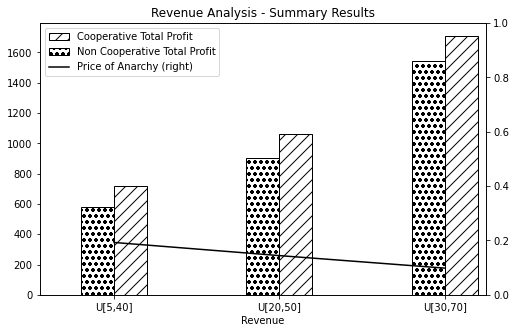

In [288]:
fig, ax = plt.subplots(figsize=(8,5)) 

hatches = ['//' ,'++', 'xx','||', 'oo','--','OO', '..', '**' , '\\\\']
df_r2.plot.bar(x="Revenue", y = "Cooperative Total Profit", color = "white", edgecolor = "black",
                hatch = "//", ax= ax, position = 0, width = 0.2,rot = 0)
df_r2.plot.bar(x="Revenue", y = "Non Cooperative Total Profit" , color = "white", edgecolor = "black" , 
                hatch = "oo",ax= ax, position = 1, width = 0.2,rot = 0)
df_r2.plot.line(x="Revenue", y = "Price of Anarchy" , color = "black", ax = ax, secondary_y = True,
                 use_index=True, rot = 0)

ax.right_ax.set_ylim(0,1)
plt.title("Revenue Analysis - Summary Results")
plt.savefig('Summary-RevenueAnalysis.png',facecolor="white", edgecolor='none')

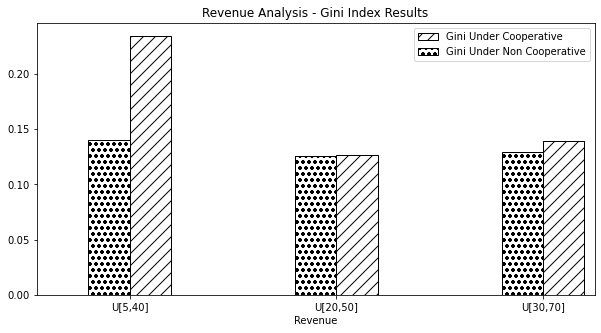

In [289]:
#Gini Index  
df4_revenue= pd.DataFrame(columns = ["Revenue",
                        "Gini Under Cooperative",
                        "Gini Under Non Cooperative", ])

for key in scenario_r.keys():
    df_gini_rate = scenario_r[key].sort_values(by = ["opt_noncoop_TP"], ignore_index = True) 
    total_non_coop = scenario_r[key]["opt_noncoop_TP"].sum()
    total_coop = scenario_r[key]["opt_coop_TP"].sum()


    normalized_TP_sum = []
    perfect_equality = []
    area_A = []
    area_A_B = []
    for shipper in range(len(df_gini_rate)):
        if shipper == 0 :
            normalized_TP_sum.append( df_gini_rate.loc[shipper,"opt_noncoop_TP"] / total_non_coop )
            perfect_equality.append( 1 / len(df_gini_rate) )
            area_A.append( perfect_equality[shipper] - normalized_TP_sum[shipper])
            area_A_B.append( perfect_equality[shipper])
        else: 
            normalized_TP_sum.append(normalized_TP_sum[shipper-1] + df_gini_rate.loc[shipper,"opt_noncoop_TP"] / total_non_coop ) 
            perfect_equality.append( perfect_equality[shipper-1] + 1 / len(df_gini_rate) )   
            area_A.append( perfect_equality[shipper] - normalized_TP_sum[shipper])
            area_A_B.append( perfect_equality[shipper])
    gini_index_noncoop = sum(area_A) / sum(area_A_B)

    normalized_TP_sum_c = []
    perfect_equality_c = []
    area_A_c = []
    area_A_B_c = []

    for shipper in range(len(df_gini_rate)):
        if shipper == 0 :
            normalized_TP_sum_c.append( df_gini_rate.loc[shipper,"opt_coop_TP"] / total_coop )
            perfect_equality_c.append( 1 / len(df_gini_rate) )
            area_A_c.append( perfect_equality_c[shipper] - normalized_TP_sum_c[shipper])
            area_A_B_c.append( perfect_equality_c[shipper])
        else: 
            normalized_TP_sum_c.append(normalized_TP_sum_c[shipper-1] + df_gini_rate.loc[shipper,"opt_coop_TP"] / total_coop ) 
            perfect_equality_c.append( perfect_equality_c[shipper-1] + 1 / len(df_gini_rate) )   
            area_A_c.append( perfect_equality_c[shipper] - normalized_TP_sum_c[shipper])
            area_A_B_c.append( perfect_equality_c[shipper])

    gini_index_coop = sum(area_A_c) / sum(area_A_B_c)
    tmp_len = len(df4_revenue)
    df4_revenue.loc[tmp_len] = ["U[" +  str(key[0]) +","+ str(key[1]) + "]",
                        gini_index_noncoop, 
                        gini_index_coop,  
                        ]
fig, ax = plt.subplots(figsize=(10,5)) 
df4_revenue.plot.bar(x="Revenue", y = "Gini Under Cooperative", 
            color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2,rot=0)
df4_revenue.plot.bar(x="Revenue", y = "Gini Under Non Cooperative" , 
            color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2, rot=0)

plt.title("Revenue Analysis - Gini Index Results")
plt.savefig('GiniIndex-RevenueAnalysis.png',facecolor="white", edgecolor='none')

In [290]:
#changing cost values - 4 scenerio
cost_range = [(0,1),(1,5),(5,10),(10,15)]
A_c = 100 
shippers_c = defaultdict(list)

revenue = {}
rate ={}  
for i in range(5):
    revenue[i] = np.random.uniform(low=5, high=30)
    rate[i] =  np.random.uniform(low=2, high=10 )


#creating shippers
for rng in cost_range:
    for i in range(5):
        shippers_c[rng ].append(
            {
                "revenue" : revenue[i],
                "cost" : np.random.uniform(low=rng[0], high=rng[1]), 
                "rate" :  rate[i]
            }
        )
        shippers_c[rng ][-1]["r/c"] = shippers_c[rng ][-1]["revenue"] / shippers_c[rng ][-1]["cost"]
        

    shippers_c[rng ] = sorted(shippers_c[rng ], key=lambda d: d['r/c'], reverse = True )

selfish_scenario_TP_c = defaultdict(list)
cooperative_scenario_TP_c = defaultdict(list)
shippers_cc = {}
scenario_c = {}
for key in shippers_c.keys():
    shippers_c[key] = opt_ind_total_profit(A_c, shippers_c[key])
    shippers_cc[key], selfish_scenario_TP_c[key] = opt_noncoop_total_profit(A_c, shippers_c[key] )
    shippers_cc[key], cooperative_scenario_TP_c[key] = opt_coop_total_profit(A_c, shippers_cc[key])
  
    #creating result tables for this test 
    #shippers table
    df_c1 = pd.DataFrame.from_dict(shippers_cc[key])
    df_c1["price of anarchy"] = 1 - (df_c1["opt_noncoop_TP"]   /  df_c1["opt_coop_TP"] )
    df_c1.loc[df_c1["price of anarchy"] <= 0, "price of anarchy"] = 0
    scenario_c[key] = df_c1
    

#summary table for cost cases: 
df_c2 = pd.DataFrame(columns = ["Waiting Cost","Non Cooperative Total Profit", "Cooperative Total Profit", "Price of Anarchy"])

for key in shippers_c.keys():
    tem_len = len(df_c2)
    df_c2.loc[tem_len] = ["U[" +  str(key[0]) +","+ str(key[1]) + "]",
                        selfish_scenario_TP_c[key], 
                        cooperative_scenario_TP_c[key],  
                        1 - (selfish_scenario_TP_c[key] / cooperative_scenario_TP_c[key]) ]

with pd.ExcelWriter("WaitingCostAnalysis.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    df_c2.to_excel(writer, sheet_name="Summary", index=False)
    for key in shippers_c :
        scenario_c[key].to_excel(writer, sheet_name=f"C={key}", index=False)

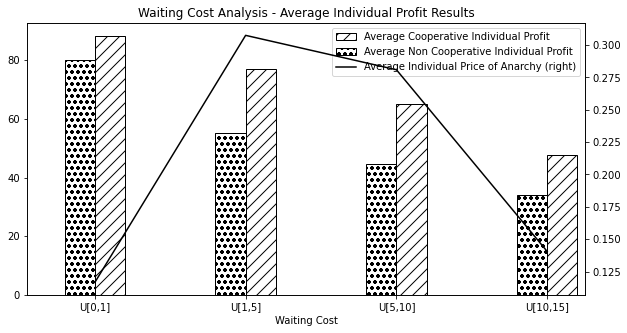

In [291]:
#average table for n shipper case: 
df3_c = pd.DataFrame(columns = ["Waiting Cost",
                            "Average Non Cooperative Individual Profit",
                            "Average Cooperative Individual Profit", 
                            "Average Individual Price of Anarchy"])

for key in scenario_c.keys():
    avg_coop_TP = scenario_c[key]["opt_coop_TP"].mean()
    avg_noncoop_TP = scenario_c[key]["opt_noncoop_TP"].mean()
    avg_poa = scenario_c[key]["price of anarchy"].mean()
    tem_len = len(df3_c)
    df3_c.loc[tem_len] = ["U[" +  str(key[0]) +","+ str(key[1]) + "]",
                        avg_noncoop_TP, 
                        avg_coop_TP,  
                        avg_poa ]

fig, ax = plt.subplots(figsize=(10,5)) 


df3_c.plot.bar(x="Waiting Cost", y = "Average Cooperative Individual Profit", 
            color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2, rot=0)
df3_c.plot.bar(x="Waiting Cost", y = "Average Non Cooperative Individual Profit" , 
            color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2, rot=0)

df3_c["Average Individual Price of Anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True,
                                                 use_index=True, kind ="line", legend = True, rot=0)

plt.title("Waiting Cost Analysis - Average Individual Profit Results")
plt.savefig('Average Individual Profit-WaitingCostAnalysis.png',facecolor="white", edgecolor='none') 

In [292]:
""" # r/c shippers 
for key in scenario_c.keys():

    fig, ax = plt.subplots(figsize=(10,5)) 
    scenario_c[key]= scenario_c[key].sort_values("r/c", )
    scenario_c[key]= scenario_c[key].reset_index(drop= True)
    scenario_c[key].plot.bar(x="r/c", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)
    scenario_c[key].plot.bar(x="r/c", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )
    scenario_c[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)


    labels= list(round(scenario_c[key]["r/c"],2))
    ax.set_xticklabels(labels, rotation=0)

    plt.title(f"Cost Analysis - Shipper Results according to their r/c values when R=U[{str(key[0])},{str(key[1])}]")
    plt.savefig(f"C =U[{   str(key[0])},{str(key[1])} ] -CostAnalysis- rc.png",facecolor="white", edgecolor='none') """

' # r/c shippers \nfor key in scenario_c.keys():\n\n    fig, ax = plt.subplots(figsize=(10,5)) \n    scenario_c[key]= scenario_c[key].sort_values("r/c", )\n    scenario_c[key]= scenario_c[key].reset_index(drop= True)\n    scenario_c[key].plot.bar(x="r/c", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)\n    scenario_c[key].plot.bar(x="r/c", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )\n    scenario_c[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)\n\n\n    labels= list(round(scenario_c[key]["r/c"],2))\n    ax.set_xticklabels(labels, rotation=0)\n\n    plt.title(f"Cost Analysis - Shipper Results according to their r/c values when R=U[{str(key[0])},{str(key[1])}]")\n    plt.savefig(f"C =U[{   str(key[0])},{str(key[1])} ] -CostAnalysis- rc.png",facecolor="white", edgecolor=\'none

In [293]:
""" #t_i^* analysis

for key in scenario_c.keys():
    fig, ax = plt.subplots(figsize=(10,5)) 
    scenario_c[key]= scenario_c[key].sort_values("t_i^*", )
    scenario_c[key]= scenario_c[key].reset_index(drop= True)
    scenario_c[key].plot.bar(x="t_i^*", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)
    scenario_c[key].plot.bar(x="t_i^*", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )
    scenario_c[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)


    labels= list(round(scenario_c[key]["t_i^*"],2))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel("$t_i^*$")

    plt.title(f"Cost Analysis - Shipper Results according to their $t_i^*$ values when R=U[{str(key[0])},{str(key[1])}]")
    plt.savefig(f"C =U[{   str(key[0])},{str(key[1])} ] -CostAnalysis -t.png",facecolor="white", edgecolor='none') """

' #t_i^* analysis\n\nfor key in scenario_c.keys():\n    fig, ax = plt.subplots(figsize=(10,5)) \n    scenario_c[key]= scenario_c[key].sort_values("t_i^*", )\n    scenario_c[key]= scenario_c[key].reset_index(drop= True)\n    scenario_c[key].plot.bar(x="t_i^*", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)\n    scenario_c[key].plot.bar(x="t_i^*", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )\n    scenario_c[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)\n\n\n    labels= list(round(scenario_c[key]["t_i^*"],2))\n    ax.set_xticklabels(labels, rotation=0)\n    ax.set_xlabel("$t_i^*$")\n\n    plt.title(f"Cost Analysis - Shipper Results according to their $t_i^*$ values when R=U[{str(key[0])},{str(key[1])}]")\n    plt.savefig(f"C =U[{   str(key[0])},{str(key[1])} ] -CostAnalysis -t

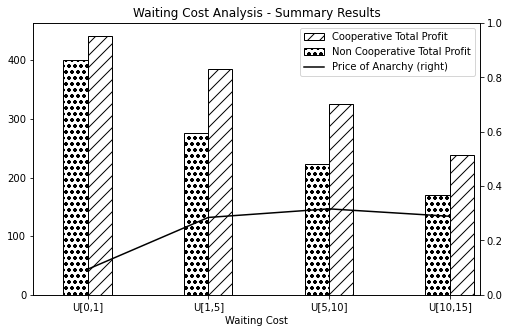

In [294]:
fig, ax = plt.subplots(figsize=(8,5)) 

hatches = ['//' ,'++', 'xx','||', 'oo','--','OO', '..', '**' , '\\\\']
df_c2.plot.bar(x="Waiting Cost", y = "Cooperative Total Profit", color = "white", edgecolor = "black",
             hatch = "//", ax= ax, position = 0, width = 0.2, rot=0)
df_c2.plot.bar(x="Waiting Cost", y = "Non Cooperative Total Profit" , color = "white", edgecolor = "black" ,
             hatch = "oo",ax= ax, position = 1, width = 0.2, rot=0)
df_c2.plot.line(x="Waiting Cost", y = "Price of Anarchy" , color = "black", ax = ax, secondary_y = True,
                 use_index=True, rot=0 )

ax.right_ax.set_ylim(0,1)
plt.title("Waiting Cost Analysis - Summary Results")
plt.savefig('Summary-CostAnalysis.png',facecolor="white", edgecolor='none')

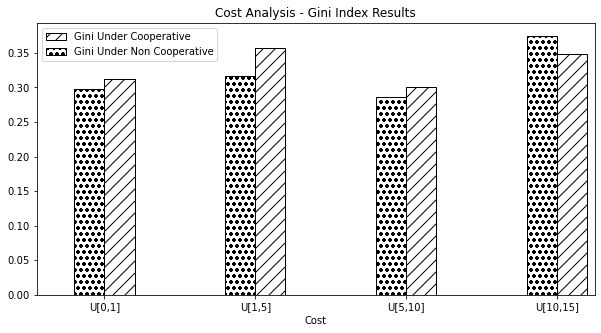

In [295]:
#Gini Index  
df4_cost= pd.DataFrame(columns = ["Cost",
                        "Gini Under Cooperative",
                        "Gini Under Non Cooperative", ])

for key in scenario_c.keys():
    df_gini_rate = scenario_c[key].sort_values(by = ["opt_noncoop_TP"], ignore_index = True) 
    total_non_coop = scenario_c[key]["opt_noncoop_TP"].sum()
    total_coop = scenario_c[key]["opt_coop_TP"].sum()


    normalized_TP_sum = []
    perfect_equality = []
    area_A = []
    area_A_B = []
    for shipper in range(len(df_gini_rate)):
        if shipper == 0 :
            normalized_TP_sum.append( df_gini_rate.loc[shipper,"opt_noncoop_TP"] / total_non_coop )
            perfect_equality.append( 1 / len(df_gini_rate) )
            area_A.append( perfect_equality[shipper] - normalized_TP_sum[shipper])
            area_A_B.append( perfect_equality[shipper])
        else: 
            normalized_TP_sum.append(normalized_TP_sum[shipper-1] + df_gini_rate.loc[shipper,"opt_noncoop_TP"] / total_non_coop ) 
            perfect_equality.append( perfect_equality[shipper-1] + 1 / len(df_gini_rate) )   
            area_A.append( perfect_equality[shipper] - normalized_TP_sum[shipper])
            area_A_B.append( perfect_equality[shipper])
    gini_index_noncoop = sum(area_A) / sum(area_A_B)

    normalized_TP_sum_c = []
    perfect_equality_c = []
    area_A_c = []
    area_A_B_c = []

    for shipper in range(len(df_gini_rate)):
        if shipper == 0 :
            normalized_TP_sum_c.append( df_gini_rate.loc[shipper,"opt_coop_TP"] / total_coop )
            perfect_equality_c.append( 1 / len(df_gini_rate) )
            area_A_c.append( perfect_equality_c[shipper] - normalized_TP_sum_c[shipper])
            area_A_B_c.append( perfect_equality_c[shipper])
        else: 
            normalized_TP_sum_c.append(normalized_TP_sum_c[shipper-1] + df_gini_rate.loc[shipper,"opt_coop_TP"] / total_coop ) 
            perfect_equality_c.append( perfect_equality_c[shipper-1] + 1 / len(df_gini_rate) )   
            area_A_c.append( perfect_equality_c[shipper] - normalized_TP_sum_c[shipper])
            area_A_B_c.append( perfect_equality_c[shipper])

    gini_index_coop = sum(area_A_c) / sum(area_A_B_c)
    tmp_len = len(df4_cost)
    df4_cost.loc[tmp_len] = ["U[" +  str(key[0]) +","+ str(key[1]) + "]",
                        gini_index_noncoop, 
                        gini_index_coop,  
                        ]
fig, ax = plt.subplots(figsize=(10,5)) 
df4_cost.plot.bar(x="Cost", y = "Gini Under Cooperative", 
            color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2, rot=0)
df4_cost.plot.bar(x="Cost", y = "Gini Under Non Cooperative" , 
            color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2, rot=0)

plt.title("Cost Analysis - Gini Index Results")
plt.savefig('GiniIndex-CostAnalysis.png',facecolor="white", edgecolor='none')

In [296]:
#changing rate values - 2 scenerio
rate_range = [(2,10), (15,25)]
A_rate = 100 
shippers_rate = defaultdict(list)
#creating shippers
for rng in rate_range:
    for i in range(5):
        shippers_rate[rng ].append(
            {
                "revenue" : np.random.uniform(low=5, high=30),
                "cost" : np.random.uniform(low=2, high=7), 
                "rate" : np.random.uniform(low=rng[0], high=rng[1] ),
            }
        )
        shippers_rate[rng ][-1]["r/c"] = shippers_rate[rng ][-1]["revenue"] / shippers_rate[rng ][-1]["cost"]
        

    shippers_rate[rng ] = sorted(shippers_rate[rng ], key=lambda d: d['r/c'], reverse = True )

selfish_scenario_TP_rate = defaultdict(list)
cooperative_scenario_TP_rate = defaultdict(list)
shippers_rrate = {}
scenario_rate = {}
for key in shippers_rate.keys():
    shippers_rate[key] = opt_ind_total_profit(A_rate, shippers_rate[key])
    shippers_rrate[key], selfish_scenario_TP_rate[key] = opt_noncoop_total_profit(A_rate, shippers_rate[key] )
    shippers_rrate[key], cooperative_scenario_TP_rate[key] = opt_coop_total_profit(A_rate, shippers_rrate[key])
  
    #creating result tables for this test 
    #shippers table
    df_rt1 = pd.DataFrame.from_dict(shippers_rrate[key])
    df_rt1["price of anarchy"] = 1 -  (df_rt1["opt_noncoop_TP"]   /  df_rt1["opt_coop_TP"] )
    df_rt1.loc[df_rt1["price of anarchy"] <= 0, "price of anarchy"] = 0
    scenario_rate[key] = df_rt1
    

#summary table for revenue cases: 
df_rt2 = pd.DataFrame(columns = ["Rate","Non Cooperative Total Profit", "Cooperative Total Profit", "Price of Anarchy"])

for key in shippers_rate.keys():
    tem_len = len(df_rt2)
    df_rt2.loc[tem_len] = ["U[" +  str(key[0]) +","+ str(key[1]) + "]",
                        selfish_scenario_TP_rate[key], 
                        cooperative_scenario_TP_rate[key],  
                        1 - (selfish_scenario_TP_rate[key] / cooperative_scenario_TP_rate[key] )]

with pd.ExcelWriter("RateAnalysis.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    df_rt2.to_excel(writer, sheet_name="Summary", index=False)
    for rng in rate_range :
        scenario_rate[rng].to_excel(writer, sheet_name=f"Rate={rng}", index=False)

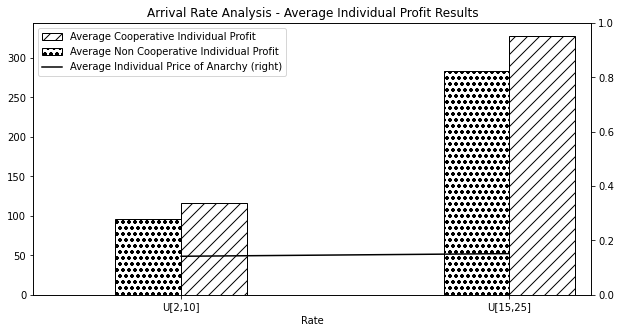

In [297]:
#average table for n shipper case: 
df3_rt = pd.DataFrame(columns = ["Rate",
                            "Average Non Cooperative Individual Profit",
                            "Average Cooperative Individual Profit", 
                            "Average Individual Price of Anarchy"])

for key in scenario_rate.keys():
    avg_coop_TP = scenario_rate[key]["opt_coop_TP"].mean()
    avg_noncoop_TP = scenario_rate[key]["opt_noncoop_TP"].mean()
    avg_poa = scenario_rate[key]["price of anarchy"].mean()
    tem_len = len(df3_rt)
    df3_rt.loc[tem_len] = ["U[" +  str(key[0]) +","+ str(key[1]) + "]",
                        avg_noncoop_TP, 
                        avg_coop_TP,  
                        avg_poa ]

fig, ax = plt.subplots(figsize=(10,5)) 

df3_rt.plot.bar(x="Rate", y = "Average Cooperative Individual Profit", 
            color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2, rot=0)
df3_rt.plot.bar(x="Rate", y = "Average Non Cooperative Individual Profit" , 
            color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2, rot=0)

df3_rt["Average Individual Price of Anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, 
                                                use_index=True, kind ="line", legend = True, rot=0)
ax.right_ax.set_ylim(0,1)
plt.title("Arrival Rate Analysis - Average Individual Profit Results")
plt.savefig('Average Individual Profit-RateAnalysis.png',facecolor="white", edgecolor='none')

In [298]:
""" #t_i^* analysis

for key in scenario_rate.keys():
    fig, ax = plt.subplots(figsize=(10,5)) 
    scenario_rate[key]= scenario_rate[key].sort_values("t_i^*", )
    scenario_rate[key]= scenario_rate[key].reset_index(drop= True)
    scenario_rate[key].plot.bar(x="t_i^*", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)
    scenario_rate[key].plot.bar(x="t_i^*", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )
    scenario_rate[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)


    labels= list(round(scenario_rate[key]["t_i^*"],2))
    ax.set_xticklabels(labels, rotation=0)
    ax.set_xlabel("$t_i^*$")

    plt.title(f"Arrival Rate Analysis - Shipper Results according to their $t_i^*$ values when R=U[{str(key[0])},{str(key[1])}]")
    plt.savefig(f"Rate =U[{   str(key[0])},{str(key[1])} ] -RateAnalysis-t.png",facecolor="white", edgecolor='none') """

' #t_i^* analysis\n\nfor key in scenario_rate.keys():\n    fig, ax = plt.subplots(figsize=(10,5)) \n    scenario_rate[key]= scenario_rate[key].sort_values("t_i^*", )\n    scenario_rate[key]= scenario_rate[key].reset_index(drop= True)\n    scenario_rate[key].plot.bar(x="t_i^*", y = "opt_noncoop_TP" , color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.2)\n    scenario_rate[key].plot.bar(x="t_i^*", y = "opt_coop_TP",color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.2 )\n    scenario_rate[key]["price of anarchy"].plot(x=ax.get_xticks(), color = "black", ax = ax, secondary_y=True, use_index=True, kind ="line", legend = True)\n\n\n    labels= list(round(scenario_rate[key]["t_i^*"],2))\n    ax.set_xticklabels(labels, rotation=0)\n    ax.set_xlabel("$t_i^*$")\n\n    plt.title(f"Arrival Rate Analysis - Shipper Results according to their $t_i^*$ values when R=U[{str(key[0])},{str(key[1])}]")\n    plt.savefig(f"Rate =U[{   str(key

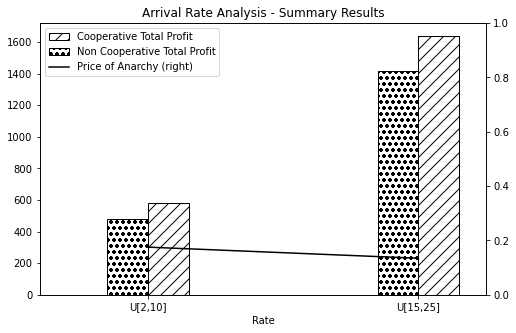

In [299]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5)) 

hatches = ['//' ,'++', 'xx','||', 'oo','--','OO', '..', '**' , '\\\\']
df_rt2.plot.bar(x="Rate", y = "Cooperative Total Profit", color = "white", edgecolor = "black",
             hatch = "//", ax= ax, position = 0, width = 0.15, rot=0)
df_rt2.plot.bar(x="Rate", y = "Non Cooperative Total Profit" , color = "white", edgecolor = "black" ,
             hatch = "oo",ax= ax, position = 1, width = 0.15, rot=0)
df_rt2.plot.line(x="Rate", y = "Price of Anarchy" , color = "black", ax = ax, secondary_y=True, use_index=True, rot=0 )
ax.right_ax.set_ylim(0,1)
plt.title("Arrival Rate Analysis - Summary Results")
plt.savefig('Summary-RateAnalysis.png',facecolor="white", edgecolor='none')

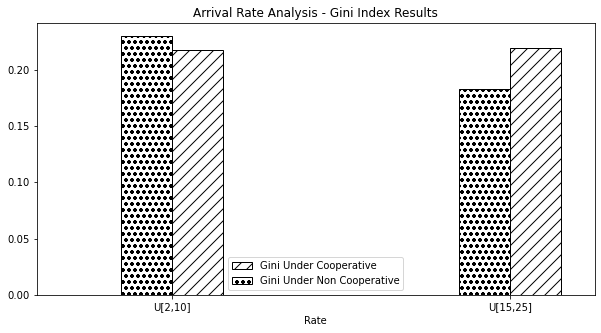

In [300]:
#Gini Index 
#average table for n shipper case: 
df4_gini_rate= pd.DataFrame(columns = ["Rate",
                        "Gini Under Cooperative",
                        "Gini Under Non Cooperative", ])

for key in scenario_rate.keys():
    df_gini_rate = scenario_rate[key].sort_values(by = ["opt_noncoop_TP"], ignore_index = True) 
    total_non_coop = scenario_rate[key]["opt_noncoop_TP"].sum()
    total_coop = scenario_rate[key]["opt_coop_TP"].sum()


    normalized_TP_sum = []
    perfect_equality = []
    area_A = []
    area_A_B = []
    for shipper in range(len(df_gini_rate)):
        if shipper == 0 :
            normalized_TP_sum.append( df_gini_rate.loc[shipper,"opt_noncoop_TP"] / total_non_coop )
            perfect_equality.append( 1 / len(df_gini_rate) )
            area_A.append( perfect_equality[shipper] - normalized_TP_sum[shipper])
            area_A_B.append( perfect_equality[shipper])
        else: 
            normalized_TP_sum.append(normalized_TP_sum[shipper-1] + df_gini_rate.loc[shipper,"opt_noncoop_TP"] / total_non_coop ) 
            perfect_equality.append( perfect_equality[shipper-1] + 1 / len(df_gini_rate) )   
            area_A.append( perfect_equality[shipper] - normalized_TP_sum[shipper])
            area_A_B.append( perfect_equality[shipper])
    gini_index_noncoop = sum(area_A) / sum(area_A_B)

    normalized_TP_sum_c = []
    perfect_equality_c = []
    area_A_c = []
    area_A_B_c = []

    for shipper in range(len(df_gini_rate)):
        if shipper == 0 :
            normalized_TP_sum_c.append( df_gini_rate.loc[shipper,"opt_coop_TP"] / total_coop )
            perfect_equality_c.append( 1 / len(df_gini_rate) )
            area_A_c.append( perfect_equality_c[shipper] - normalized_TP_sum_c[shipper])
            area_A_B_c.append( perfect_equality_c[shipper])
        else: 
            normalized_TP_sum_c.append(normalized_TP_sum_c[shipper-1] + df_gini_rate.loc[shipper,"opt_coop_TP"] / total_coop ) 
            perfect_equality_c.append( perfect_equality_c[shipper-1] + 1 / len(df_gini_rate) )   
            area_A_c.append( perfect_equality_c[shipper] - normalized_TP_sum_c[shipper])
            area_A_B_c.append( perfect_equality_c[shipper])

    gini_index_coop = sum(area_A_c) / sum(area_A_B_c)
    tmp_len = len(df4_gini_rate)
    df4_gini_rate.loc[tmp_len] = ["U[" +  str(key[0]) +","+ str(key[1]) + "]",
                        gini_index_noncoop, 
                        gini_index_coop,  
                        ]
fig, ax = plt.subplots(figsize=(10,5)) 
df4_gini_rate.plot.bar(x="Rate", y = "Gini Under Cooperative", 
            color = "white", edgecolor = "black", hatch = "//", ax= ax, position = 0, width = 0.15,rot = 0)
df4_gini_rate.plot.bar(x="Rate", y = "Gini Under Non Cooperative" , 
            color = "white", edgecolor = "black" , hatch = "oo",ax= ax, position = 1, width = 0.15,rot = 0)

plt.title("Arrival Rate Analysis - Gini Index Results")
plt.savefig('GiniIndex-RateAnalysis.png',facecolor="white", edgecolor='none')